# analysis of pep2vec result

In [94]:
import itertools
import os

import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from gensim.models import Word2Vec

%matplotlib inline

### parameters and functions

In [95]:
alphabet = list('ACDEFGHIKLMNPQRSTVWY')
dimer = [''.join(i) for i in itertools.product(alphabet, repeat=2)]
trimer = [''.join(i) for i in itertools.product(alphabet, repeat=3)]

trimer_n = ['n' + i for i in trimer]
trimer_c = ['c' + i for i in trimer]

keyedvector to data frame

In [96]:
def wv_to_df(wv, words):
    sr_list = []
    for i in words:
        sr = pd.Series(wv[i], name=i)
        sr_list.append(sr)
    df = pd.concat(sr_list, axis=1).T
    
    return df

merge N vector and C vector

In [97]:
def merge_nc(df_nc):
    df_n = df_nc.loc[trimer_n]
    df_n.index = trimer
    df_c = df_nc.loc[trimer_c]
    df_c.index = trimer
    
    # concatenate
    df = pd.concat([df_n, df_c], axis=1)
    # sum
#     df = df_n + df_c
    
    df.columns = xrange(df.shape[1])
    
    return df

dimension reduction

In [98]:
def reduce_dimension(X, method = 'tsne'):
    if method == 'tsne':
        Y = TSNE(learning_rate=10).fit_transform(X)
    else:
        Y = PCA().fit_transform(X)

    Y *= 100 / (Y.max() - Y.min())

    return Y

scatter plot

In [99]:
def scatter_plot(Y, target, color=False, label=False, to_sort=False, alpha=0.5):
    target = pd.Series(target)
    
    # first draw point without labels
    if label:
        plt.scatter(Y[target.isnull(), 0], Y[target.isnull(), 1], c='grey', alpha=0.05)
        Y = Y[target.notnull(), :]
        target = target[target.notnull()]
        # reset index
        target.reset_index(drop=True, inplace=True)
    
    # color
    if not color:
        plt.scatter(Y[:, 0], Y[:, 1])
    
    else:
        if to_sort:
            # sort data
            idx = target.sort_values().index
            target = target[idx]
            Y = Y[idx, :]
        
        if len(set(target)) > 30:
            plt.scatter(Y[:, 0], Y[:, 1], c=target, alpha=alpha)
        else:
            # categorical
            factor = list(set(target))
            color_dict = dict(zip(factor, xrange(len(factor))))
            print color_dict
            plt.scatter(Y[:, 0], Y[:, 1], c=target.map(color_dict), alpha=alpha)    
    
    # text label
    if label:
        for i in xrange(len(target)):
            plt.text(Y[i, 0] + 1, Y[i, 1] + 1, target[i])

### load vector

pep2vec

In [100]:
# file_vector = 'G:/data/uniprot/pretrained_model/pep2vec_v40_w1.model'
# wv = Word2Vec.load(file_vector).wv
# pep2vec_nc = wv_to_df(wv, trimer_n + trimer_c)

# # pep2vec = wv_to_df(wv, trimer)

# print pep2vec_nc.shape
# pep2vec_nc.head(1)

merge N vector and C vector

In [101]:
# pep2vec = merge_nc(pep2vec_nc)

# print pep2vec.shape
# pep2vec.head(1)

tensorflow

In [142]:
file_vector = 'G:/data/uniprot/tf_model/pep1_n3c3_v40_e4_lr02/embedding_5.npy'

pep2vec = np.load(file_vector)
pep2vec = pd.DataFrame(pep2vec)

# pep2vec.index = trimer
pep2vec.index = alphabet

print pep2vec.shape
pep2vec.head()

(20, 40)


,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
A,-0.101192,-0.211507,-0.019834,-0.040145,0.121559,0.053716,0.093700,0.143807,-0.008595,0.046140,...,0.085386,0.024918,0.207240,-0.050435,0.101729,0.017080,0.081036,0.023698,0.055377,-0.090787
C,-0.137032,-0.135289,-0.013346,-0.116781,0.102518,0.008673,0.054473,0.119112,-0.028848,0.034679,...,0.055731,0.004934,0.200924,-0.031454,0.063401,0.000666,0.090856,0.048440,0.048550,-0.058315
D,-0.108841,-0.190146,-0.016318,-0.035174,0.116072,0.044689,0.083183,0.140370,-0.012502,0.048669,...,0.089579,0.030029,0.204193,-0.035215,0.117962,0.009497,0.074646,0.028456,0.056138,-0.090630
E,-0.099647,-0.201851,-0.024975,-0.024827,0.116139,0.059919,0.088799,0.125647,-0.016803,0.063718,...,0.087108,0.036098,0.218487,-0.041744,0.127034,0.014733,0.088596,0.022955,0.042786,-0.102197
F,-0.113808,-0.203673,-0.013718,-0.066285,0.121417,0.036015,0.066282,0.145321,-0.025198,0.038711,...,0.081683,0.027367,0.201684,-0.042792,0.093149,0.014208,0.078904,0.018935,0.058531,-0.078980


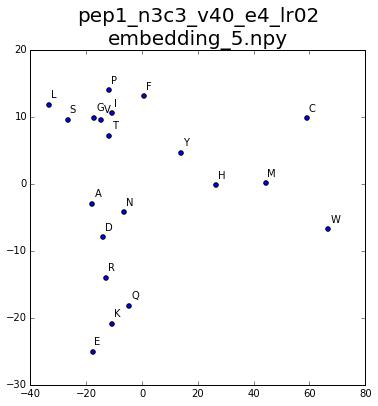

In [143]:
pep2vec_aa = pep2vec

plt.rcParams['figure.figsize'] = (6, 6)

Y = reduce_dimension(pep2vec_aa, 'pca')

# flip coordinate to let C locate in the top right
Y *= np.sign(Y[1, :])

scatter_plot(Y[:, :2], pep2vec_aa.index, label=True)
fname = '\n'.join(file_vector.split('/')[-2:])
plt.title(fname, fontsize=20)

### pysiochemical property

In [103]:
df = pd.read_csv('../data/peptide_property.tsv', sep='\t')
df.head(1)

,peptide,mass,charge,hydrophobicity,aliphatic,isoelectric
0,AAA,231.25164,-0.002016,1.8,100.0,6.099982


run PCA

<matplotlib.colorbar.Colorbar instance at 0x00000000145BC3C8>

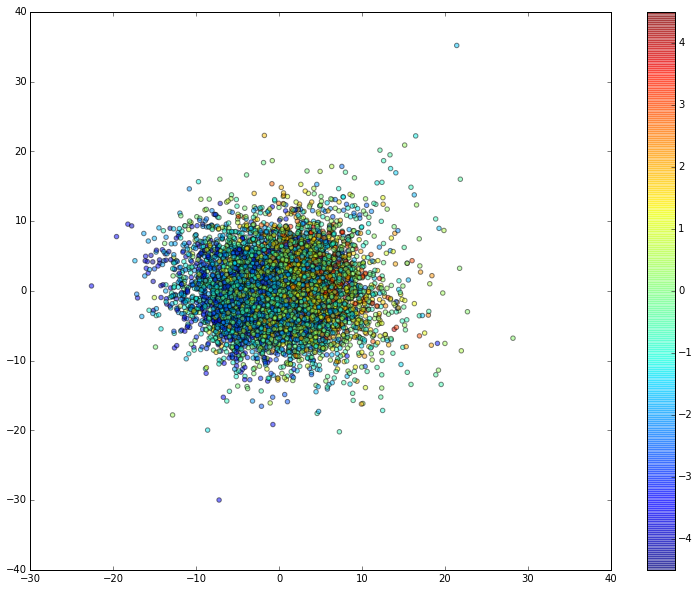

In [104]:
plt.rcParams['figure.figsize'] = (13, 10)
Y = reduce_dimension(pep2vec, method='pca')

scatter_plot(Y[:, :2], df['hydrophobicity'], color=True)

plt.colorbar()

### similar tripepetides

In [105]:
tripep = ['AIA', 'AVA', 'ALA', 'ADA', 'AEA', 'CCC']
dict_tripep = dict(zip(tripep, tripep))

df['eg'] = df['peptide'].map(lambda x: dict_tripep.get(x))

df.head(1)

,peptide,mass,charge,hydrophobicity,aliphatic,isoelectric,eg
0,AAA,231.25164,-0.002016,1.8,100.0,6.099982,None


plot

Wall time: 23 ms
{'ALA': 0, 'AEA': 1, 'ADA': 2, 'AIA': 3, 'AVA': 4, 'CCC': 5}


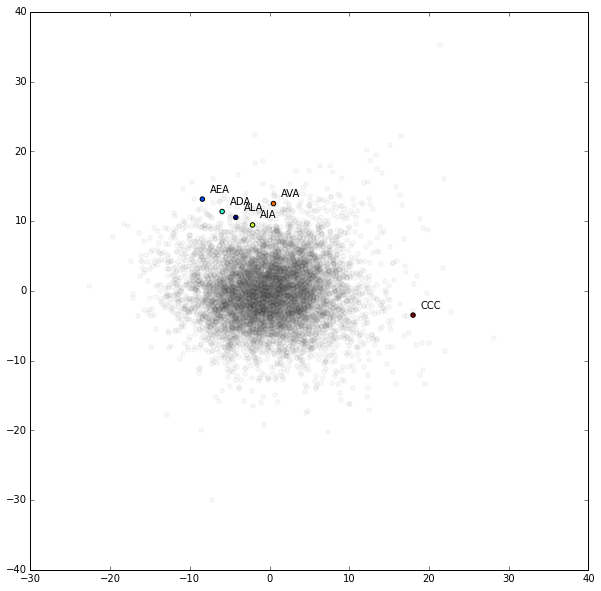

In [106]:
plt.rcParams['figure.figsize'] = (10, 10)

%time Y = reduce_dimension(pep2vec, method='pca')
scatter_plot(Y[:, :2], df['eg'], color=True, label=True, alpha=1)

### comparison between N-vec and C-vec

In [107]:
# lab = [i for i in ['n', 'c'] for __ in xrange(pep2vec_nc.shape[0] / 2)]

# plt.rcParams['figure.figsize'] = (10, 10)
# Y = reduce_dimension(pep2vec_nc, 'pca')
# scatter_plot(Y[:, :2], lab, color=True)

example

In [108]:
# tripep = [i + j for i in ['n', 'c'] for j in ['AIA', 'AVA', 'ALA', 'ADA', 'AEA']]
# dict_tripep = dict(zip(tripep, tripep))
# eg = pep2vec_nc.index.map(lambda x: dict_tripep.get(x))

# scatter_plot(Y[:, :2], eg, color=True, label=True)

### amino acids level

calculate sum vector

In [121]:
sr_list = []

for a in alphabet:
    vec = np.zeros(pep2vec.shape[1])
    for i, j in itertools.product(alphabet, repeat=2):
        vec += pep2vec.loc[i + a + j]
    sr = pd.Series(vec, name=a)
    sr_list.append(sr)

pep2vec_aa = pd.concat(sr_list, axis=1).T

print pep2vec_aa.shape
pep2vec_aa.head(1)

KeyError: 'the label [AAA] is not in the [index]'

run t-SNE and PCA

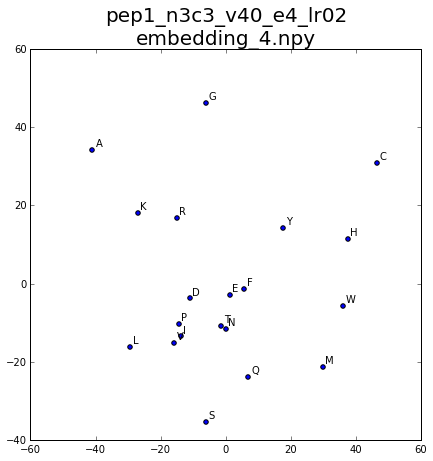

In [123]:
plt.rcParams['figure.figsize'] = (7, 7)

Y = reduce_dimension(pep2vec_aa, 'pca')

# flip coordinate to let C locate in the top right
Y *= np.sign(Y[1, :])

scatter_plot(Y[:, :2], pep2vec_aa.index, label=True)
fname = '\n'.join(file_vector.split('/')[-2:])
plt.title(fname, fontsize=20)

split N vector and C vector

In [111]:
# sr_list = []

# for prefix in ['n', 'c']:
#     for a in alphabet:
#         vec = np.zeros(pep2vec_nc.shape[1])
#         for i, j in itertools.product(alphabet, repeat=2):
#             vec += pep2vec_nc.loc[prefix + i + a + j]
#         sr = pd.Series(vec, name=prefix + a)
#         sr_list.append(sr)

# pep2vec_aa_nc = pd.concat(sr_list, axis=1).T

# print pep2vec_aa_nc.shape
# pep2vec_aa_nc.head(1)

In [112]:
# plt.rcParams['figure.figsize'] = (16, 8)
# n = pep2vec_aa_nc.shape[0]

# plt.subplot(1, 2, 1)

# Y = reduce_dimension(pep2vec_aa_nc.iloc[:n/2, :], 'pca')
# # flip coordinate to let C locate in the top right
# Y *= np.sign(Y[1, :])

# scatter_plot(Y[:, :2], pep2vec_aa_nc.index[:n/2], label=True)
# plt.title(os.path.basename(file_vector) + '\tsplit', fontsize=20)

# plt.subplot(1, 2, 2)

# Y = reduce_dimension(pep2vec_aa_nc.iloc[n/2:, :], 'pca')
# # flip coordinate to let C locate in the top right
# Y *= np.sign(Y[1, :])

# scatter_plot(Y[:, :2], pep2vec_aa_nc.index[n/2:], label=True)
# plt.title(os.path.basename(file_vector) + '\tsplit', fontsize=20)

blosum62

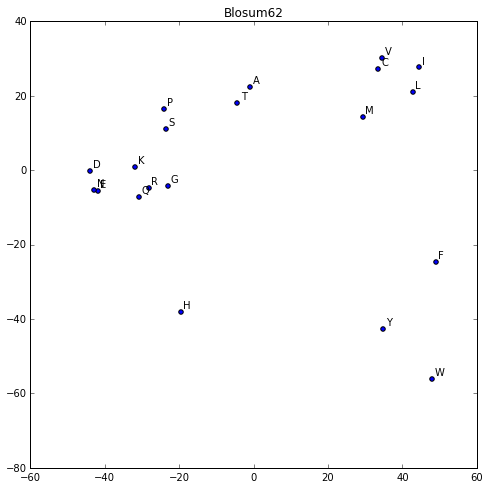

In [113]:
blosum = pd.read_csv('../data/blosum62.txt', delim_whitespace=True)

Y = reduce_dimension(blosum, 'pca')
# flip coordinate to let C locate in the top right
Y *= np.sign(Y[1, :])

plt.rcParams['figure.figsize'] = (8, 8)
scatter_plot(Y, blosum.index, label=True)
plt.title('Blosum62')

### cleavage site (hexapeptide)

In [114]:
# df_cle = pd.read_csv('../data/cleavage_sample.tsv', sep='\t')
# df_cle['C'] = df_cle['peptide'].map(lambda x: x[:3])
# df_cle['D'] = df_cle['peptide'].map(lambda x: x[3:])

# # shuffle
# df_cle = df_cle.sample(frac=1)

# print df_cle.shape
# df_cle.head(1)

encoding

In [115]:
# vec1 = pep2vec.loc[df_cle['C']]
# vec1.index = df_cle['peptide']
# vec2 = pep2vec.loc[df_cle['D']]
# vec2.index = df_cle['peptide']

# cleavage_vec = pd.concat([vec1, vec2], axis=1)

# print cleavage_vec.shape
# cleavage_vec.head(1)

PCA

In [116]:
# plt.rcParams['figure.figsize'] = (13, 10)

# Y = reduce_dimension(cleavage_vec, method='pca')
# # scatter_plot(Y[:, :2], df_cle['prob'], color=True, alpha=0.2)
# plt.colorbar()

concatenate N vector and C vector

In [117]:
# d = pep2vec.shape[1]

# vec1 = pep2vec.loc[df_cle['C']].iloc[:, :d/2]
# vec1.index = df_cle['peptide']
# vec2 = pep2vec.loc[df_cle['D']].iloc[:, d/2:]
# vec2.index = df_cle['peptide']

# cleavage_vec = pd.concat([vec1, vec2], axis=1)

# print cleavage_vec.shape
# cleavage_vec.head(1)

In [118]:
# plt.rcParams['figure.figsize'] = (13, 10)

# Y = reduce_dimension(cleavage_vec, method='pca')
# # scatter_plot(Y[:, :2], df_cle['prob'], color=True, alpha=0.2)
# plt.colorbar()